## Titanic Machine Learning Exercise

The purpose of this exercise is to practice machine learning techniques in Python. The data and inspiration is from Kaggle's [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview).

"In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)."

The values in the second column ("Survived") can be used to determine whether each passenger survived or not:
* if it's a "1", the passenger survived.
* if it's a "0", the passenger died.

Variable Definition	Key: 

* survival	Survival	0 = No, 1 = Yes
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	Sex	
* Age	Age in years	
* sibsp	# of siblings / spouses aboard the Titanic	
* parch	# of parents / children aboard the Titanic	
* ticket	Ticket number	
* fare	Passenger fare	
* cabin	Cabin number	
* embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Other variable notes:
    
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Pushing notebook to GitHub: https://towardsdatascience.com/how-to-use-git-github-with-jupyter-notebook-7144d6577b44

> It is a simple binary classification problem, and all you need to do is predict if a particular passenger survived. The best thing about this dataset is that all the pre-processing is done for you. You have a nice, clean dataset to train your machine learning model.
**Since this is a classification problem, you can choose to use algorithms like logistic regression, decision trees, and random forests to build the predictive model. You can also choose gradient boosting models like an XGBoost classifier for this beginner-level machine learning project to get better results.**

From https://www.kdnuggets.com/2021/09/20-machine-learning-projects-hired.html

### Reading in the Data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import poisson

In [2]:
# Read in the data to train the model
train=pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
# Overview of data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


By looking at these basic summary statistics and the first few rows of our data, we can see that we have 891 observations. 1 means the passenger survived, and 0 means that the passenger died. We can see that the average age of our passengers was around 30 years old.

Let's do a brief exploratory data analysis before we fit our machine learning models.

### Exploratory Data Analysis

In [12]:
print("Are there null values?", train.isnull().values.any())
print(train.isnull().sum())

Are there null values? True
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Here, we can see there are null values in Age, Cabin, and Embarked.

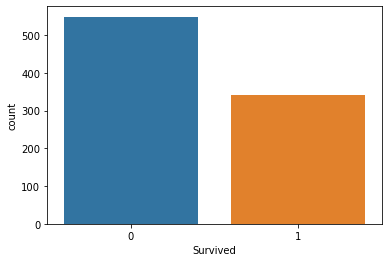

In [19]:
sns.countplot(data=train, x="Survived")
plt.show()

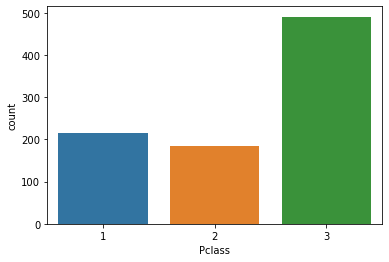

In [20]:
sns.countplot(data=train, x="Pclass")
plt.show()

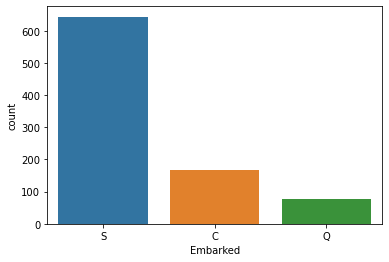

In [21]:
sns.countplot(data=train, x="Embarked")
plt.show()

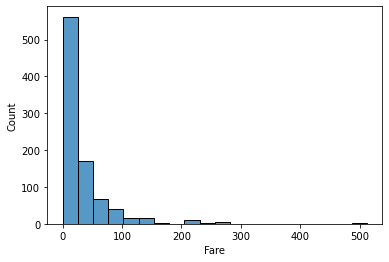

In [25]:
sns.histplot(data=train, x="Fare", bins=20)
plt.show()

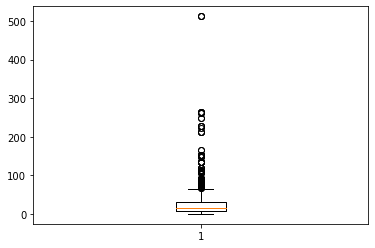

In [35]:
plt.boxplot(train['Fare'])
plt.show()

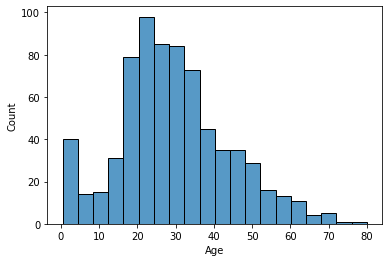

In [38]:
sns.histplot(data=train, x="Age")
plt.show()

In [57]:
mn=train.Age.min()
mx=train.Age.max()
x=np.linspace(mn,mx,100)
mean=train.Age.mean()
std=train.Age.std()
z=norm.pdf(x,mean,std)

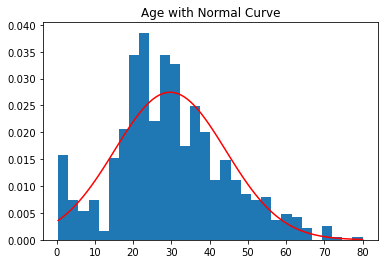

In [61]:
plt.hist(train['Age'], density=True, bins=30)
plt.plot(x,z,color="red")
plt.title("Age with Normal Curve")
plt.show()

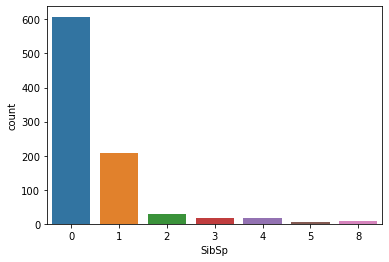

In [40]:
sns.countplot(data=train, x="SibSp")
plt.show()

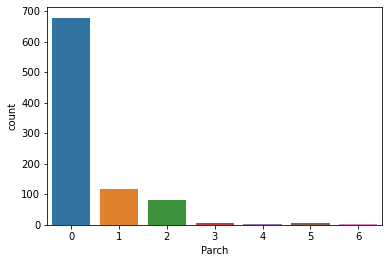

In [42]:
sns.countplot(data=train, x="Parch")
plt.show()

### Machine Learning Models

The code cell below looks for patterns in four different columns ("Pclass", "Sex", "SibSp", and "Parch") of the data. It constructs the trees in the random forest model based on patterns in the train.csv file, before generating predictions for the passengers in test.csv. The code also saves these new predictions in a CSV file submission.csv.

In [ ]:
# From https://www.kaggle.com/alexisbcook/titanic-tutorial
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('submission.csv', index=False)
#print("Your submission was successfully saved!")